In [1]:
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import L1L2

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load Dataset

In [2]:
# dataset diambil dari https://github.com/robsalgado/personal_data_science_projects/tree/master/mulitclass_text_class
df = pd.read_csv("df.csv",dtype=object)
df.head()

,content,label
0,Unions representing workers at Turner Newall...,Business
1,"SPACE.com - TORONTO, Canada -- A second\team o...",SciTech
2,AP - A company founded by a chemistry research...,SciTech
3,AP - It's barely dawn when Mike Fitzpatrick st...,SciTech
4,AP - Southern California's smog-fighting agenc...,SciTech


# One Hot Endocder for label data

In [3]:
category = pd.get_dummies(df.label)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='label')
df_baru['content'] = df_baru['content'].str.lower()
df_baru.head()

,content,Business,SciTech,Sports,World
0,unions representing workers at turner newall...,1,0,0,0
1,"space.com - toronto, canada -- a second\team o...",0,1,0,0
2,ap - a company founded by a chemistry research...,0,1,0,0
3,ap - it's barely dawn when mike fitzpatrick st...,0,1,0,0
4,ap - southern california's smog-fighting agenc...,0,1,0,0


# Split x y

In [4]:
x = df_baru['content'].values
y = df_baru[['Business', 'SciTech', 'Sports', 'World']].values

# Tokenizer

In [5]:
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(x)

In [6]:
sekuens_x = tokenizer.texts_to_sequences(x)

# Padding

In [7]:
padded_x = pad_sequences(sekuens_x) 

# Split train test val

In [8]:
x_train, x_test, y_train, y_test = train_test_split(padded_x, y, test_size=0.2, random_state = 4)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 4)

# Calls the function model to be used 

https://towardsdatascience.com/machine-learning-model-regularization-in-practice-an-example-with-keras-and-tensorflow-2-0-52a96746123e

https://towardsdatascience.com/batch-normalization-in-practice-an-example-with-keras-and-tensorflow-2-0-b1ec28bde96f

https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=128),
    
    tf.keras.layers.LSTM(128),
        
    tf.keras.layers.Dense(128, kernel_regularizer=L1L2(l1=0.01, l2=0.01), activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(128, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(128, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(128, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(128, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),    
    
    tf.keras.layers.Dense(4, activation='softmax')
])

# Call EarlyStopping

In [10]:
early_stop = EarlyStopping(monitor='categorical_accuracy', patience=5, baseline = 0.8, restore_best_weights = True)

In [11]:
# class MyThresholdCallback(tf.keras.callbacks.Callback):
#     def __init__(self, threshold):
#         super(MyThresholdCallback, self).__init__()
#         self.threshold = threshold

#     def on_epoch_end(self, epoch, logs=None): 
#         accuracy = logs["acc"]
#         if accuracy >= self.threshold:
#             self.model.stop_training = True
            
            
# early_stop = MyThresholdCallback(threshold=8.0)

# Call optimizer for model

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['categorical_accuracy'])

# Train the data

In [13]:
%%time
num_epochs = 100
fit = model.fit(x_train, 
                y_train, 
                epochs=num_epochs, 
                validation_data=(x_val, y_val),
#                 validation_split=0.2,       
                callbacks = [early_stop]
)

Epoch 1/100
152/152 [==============================] - 17s 91ms/step - loss: 16.3261 - categorical_accuracy: 0.2876 - val_loss: 11.6949 - val_categorical_accuracy: 0.3734
Epoch 2/100
152/152 [==============================] - 15s 100ms/step - loss: 8.1800 - categorical_accuracy: 0.6151 - val_loss: 6.2150 - val_categorical_accuracy: 0.2689
Epoch 3/100
152/152 [==============================] - 16s 105ms/step - loss: 4.0816 - categorical_accuracy: 0.8160 - val_loss: 3.7479 - val_categorical_accuracy: 0.5724
Epoch 4/100
152/152 [==============================] - 16s 103ms/step - loss: 2.5318 - categorical_accuracy: 0.8727 - val_loss: 2.4325 - val_categorical_accuracy: 0.7352
Epoch 5/100
152/152 [==============================] - 13s 89ms/step - loss: 1.7528 - categorical_accuracy: 0.9077 - val_loss: 1.8164 - val_categorical_accuracy: 0.7903
Epoch 6/100
152/152 [==============================] - 13s 87ms/step - loss: 1.2028 - categorical_accuracy: 0.9350 - val_loss: 1.4781 - val_categorica

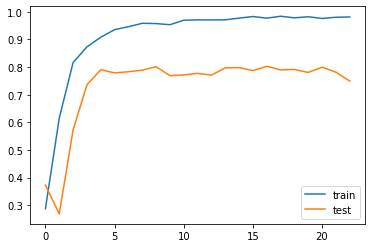

In [14]:
plt.plot(fit.history['categorical_accuracy'], label='train')
plt.plot(fit.history['val_categorical_accuracy'], label='test')
plt.legend()
plt.show()

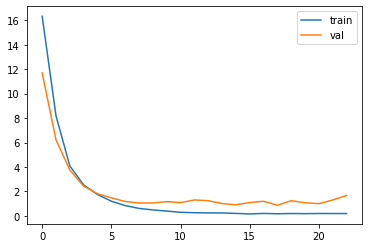

In [15]:
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], label='val')
plt.legend()
plt.show()

In [16]:
train_loss, train_acc = model.evaluate(x_train, y_train, steps=16)
val_loss, val_acc = model.evaluate(x_val, y_val, steps=16)
test_loss, test_acc = model.evaluate(x_test, y_test, steps=16)

print('\nTrain: %.3f, val: %.3f, test: %.3f,' % (train_acc, val_acc, test_acc))

16/16 [==============================] - 1s 68ms/step - loss: 0.8587 - categorical_accuracy: 0.7987

Train: 0.989, val: 0.789, test: 0.799,


# Save Model

In [17]:
filename = 'lstm.h5'
model.save(filename)